# Phytoplankton biomass for warm and cold years within the $2^{nd}$ cycle of the model run

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import hvplot.xarray
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats
import os
import matplotlib.gridspec as gridspec

In [2]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [3]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## input file

In [4]:
ppC_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_ppC.*.nc', recursive=True))
ppC_ds = xr.open_mfdataset(ppC_inds,concat_dim='time', combine='nested')
mp1C_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_mp1C.*.nc', recursive=True))
mp1C_ds = xr.open_mfdataset(mp1C_inds,concat_dim='time', combine='nested')
mp2C_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_mp2C.*.nc', recursive=True))
mp2C_ds = xr.open_mfdataset(mp2C_inds,concat_dim='time', combine='nested')
mp3C_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_mp3C.*.nc', recursive=True))
mp3C_ds = xr.open_mfdataset(mp3C_inds,concat_dim='time', combine='nested')
mp4C_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_mp4C.*.nc', recursive=True))
mp4C_ds = xr.open_mfdataset(mp4C_inds,concat_dim='time', combine='nested')
diazC_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_diazC.*.nc', recursive=True))
diazC_ds = xr.open_mfdataset(diazC_inds,concat_dim='time', combine='nested')
diat1C_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_diat1C.*.nc', recursive=True))
diat1C_ds = xr.open_mfdataset(diat1C_inds,concat_dim='time', combine='nested')
diat2C_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_diat2C.*.nc', recursive=True))
diat2C_ds = xr.open_mfdataset(diat2C_inds,concat_dim='time', combine='nested')
diat3C_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_diat3C.*.nc', recursive=True))
diat3C_ds = xr.open_mfdataset(diat3C_inds,concat_dim='time', combine='nested')

In [5]:
phytoC = np.stack([ppC_ds.ppC, mp1C_ds.mp1C, diazC_ds.diazC, 
                               mp2C_ds.mp2C, diat1C_ds.diat1C, diat2C_ds.diat2C, 
                               mp3C_ds.mp3C, diat3C_ds.diat3C, mp4C_ds.mp4C])

In [6]:
phytoC_ds_inter = np.empty([9,63,12,15,180,360])
phytoC_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    phytoC_ds_inter[:,i,:,:,:,:] = phytoC[:,x[i]:x[i]+12,:,:,:]

In [7]:
phytoC_bm = np.sum(phytoC_ds_inter, axis=3) * 10/150 #integrate over depth #mmol m-3
phytoC_bm_total = np.nansum(phytoC_bm,axis=0) * 12.011 *1000 # ug C m-3 --> ugC m^{-3}

In [8]:
phytoC_bm_total.shape

(63, 12, 180, 360)

## Selecting warm adn cold years 

In [9]:
temp_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_TEMP*.nc', recursive=True))
ds= xr.open_mfdataset(temp_inds,concat_dim='time', combine='nested') # Full 62 years of second cycle

In [10]:
temp_ds_inter = np.empty([63,12,180,360])
temp_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    temp_ds_inter[i,:,:,:] = ds.TEMP[x[i]:x[i]+12,0,:,:]

In [11]:
temp_arctic = np.nanmean(temp_ds_inter[:,:,149:180,:], axis=(2,3))
temp_arctic_anom = temp_arctic-np.nanmean(temp_arctic,axis=0)
err_ao = np.nanstd(temp_arctic_anom,axis=(0,1))

# Selecting the warm and cold years as less or more than zero 
#cold_years_arctic = np.where(np.nanmean(temp_arctic_anom,axis=1) < 0)
#warm_years_arctic = np.where(np.nanmean(temp_arctic_anom,axis=1) > 0)

# Selecting the warm and cold years as less or more than 1/3 of standard deviation 
cold_years_arctic = np.where(np.nanmean(temp_arctic_anom,axis=1) < -(err_ao/2))
warm_years_arctic = np.where(np.nanmean(temp_arctic_anom,axis=1) > (err_ao/2))

In [12]:
cold_years = phytoC_bm_total[cold_years_arctic,:,:,:] # 1/2 standard deviation 
warm_years = phytoC_bm_total[warm_years_arctic,:,:,:] # 1/2 standard deviation 

In [63]:
#cold_years = phytoC_bm_total[14:26,:,:,:] # 1962-1973
#warm_years = phytoC_bm_total[51:62,:,:,:] # 1998-2009

In [13]:
warm_years.shape

(1, 17, 12, 180, 360)

In [14]:
mp1C_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_mp1C.*.nc', recursive=True))
mp1C_ds = xr.open_mfdataset(mp1C_inds,concat_dim='time', combine='nested')

## Warm vs Cold years

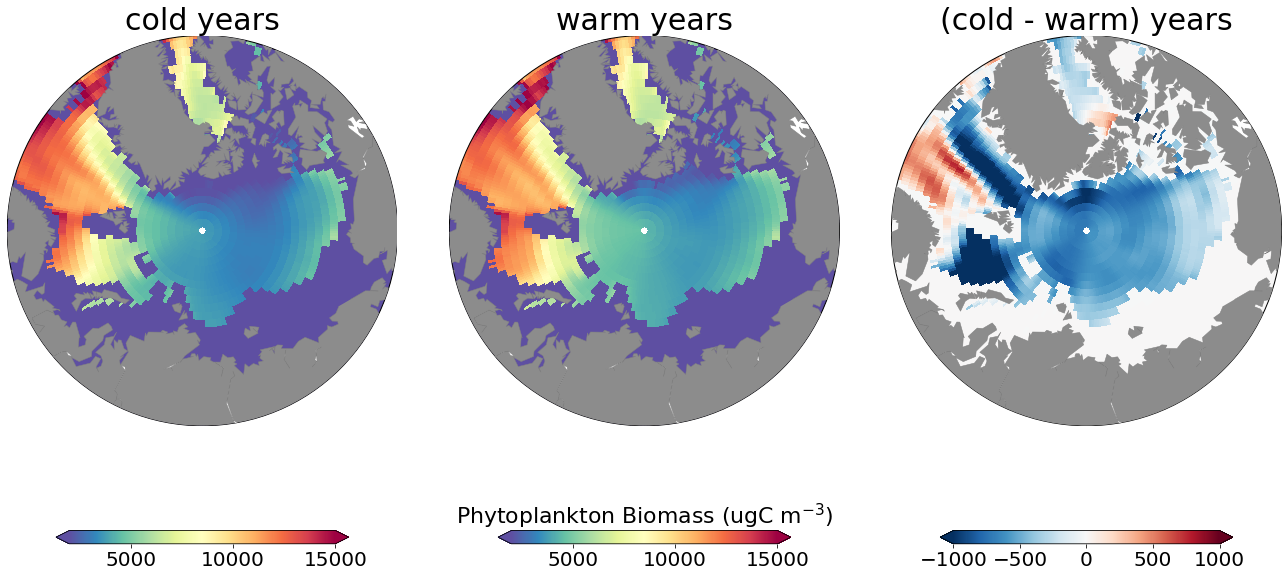

In [15]:
fig = plt.figure(figsize=(18, 10))
lat = mp1C_ds.lat

## Cold Years 
ax = fig.add_subplot(1, 3, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
winter, lon = add_cyclic_point(cold_years.mean(axis=(0,1,2)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,winter,cmap='Spectral_r', vmin = 2000, vmax = 15000)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.75, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('cold years', fontsize =30)

## Warm Years
ax = fig.add_subplot(1, 3, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
spring, lon = add_cyclic_point(warm_years.mean(axis=(0,1,2)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,spring,cmap='Spectral_r', vmin = 2000, vmax = 15000)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.75, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('Phytoplankton Biomass (ugC m$^{-3}$)', fontsize=22)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('warm years', fontsize =30)

# Cold - Warm Years 
ax = fig.add_subplot(1, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
spring, lon = add_cyclic_point(cold_years.mean(axis=(0,1,2))- warm_years.mean(axis=(0,1,2)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,spring,cmap='RdBu_r', vmin = -1000, vmax = 1000)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.75, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('(cold - warm) years', fontsize =30)

fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/phyto_biomass_warm_vs_cold_50std.png', dpi=600, bbox_inches='tight')

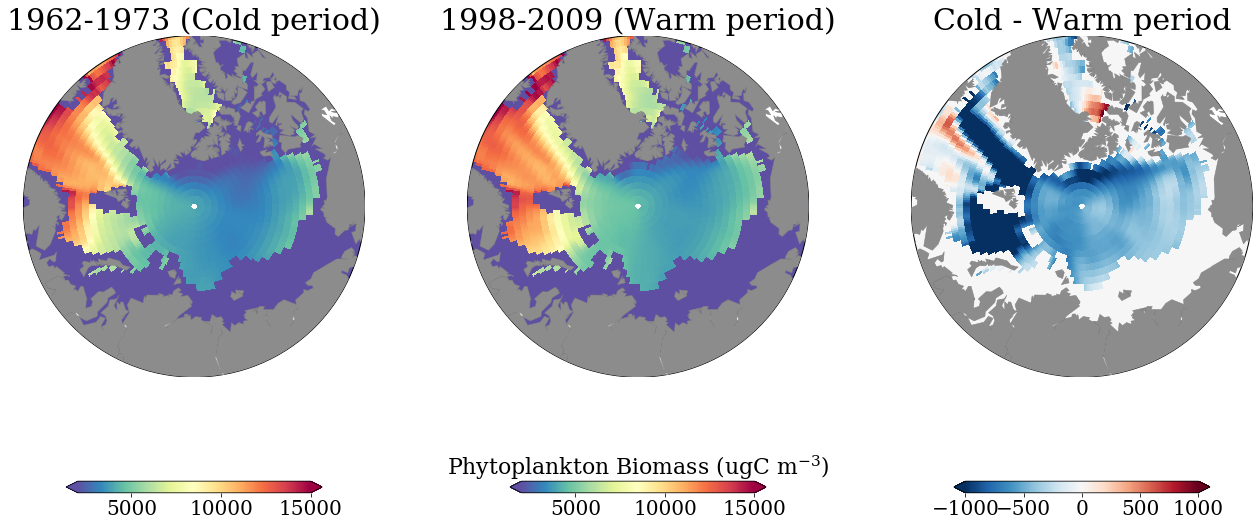

In [69]:
fig = plt.figure(figsize=(18, 10))
lat = mp1C_ds.lat

## Cold Years 
ax = fig.add_subplot(1, 3, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
winter, lon = add_cyclic_point(cold_years.mean(axis=(0,1)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,winter,cmap='Spectral_r', vmin = 2000, vmax = 15000)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.75, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('1962-1973 (Cold period)', fontsize =30)

## Warm Years
ax = fig.add_subplot(1, 3, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
spring, lon = add_cyclic_point(warm_years.mean(axis=(0,1)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,spring,cmap='Spectral_r', vmin = 2000, vmax = 15000)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.75, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('Phytoplankton Biomass (ugC m$^{-3}$)', fontsize=22)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('1998-2009 (Warm period)', fontsize =30)

# Cold - Warm Years 
ax = fig.add_subplot(1, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
spring, lon = add_cyclic_point(cold_years.mean(axis=(0,1))- warm_years.mean(axis=(0,1)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,spring,cmap='RdBu_r', vmin = -1000, vmax = 1000)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.75, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Cold - Warm period', fontsize =30)

fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/phyto_biomass_warm_vs_cold.png', dpi=600, bbox_inches='tight')

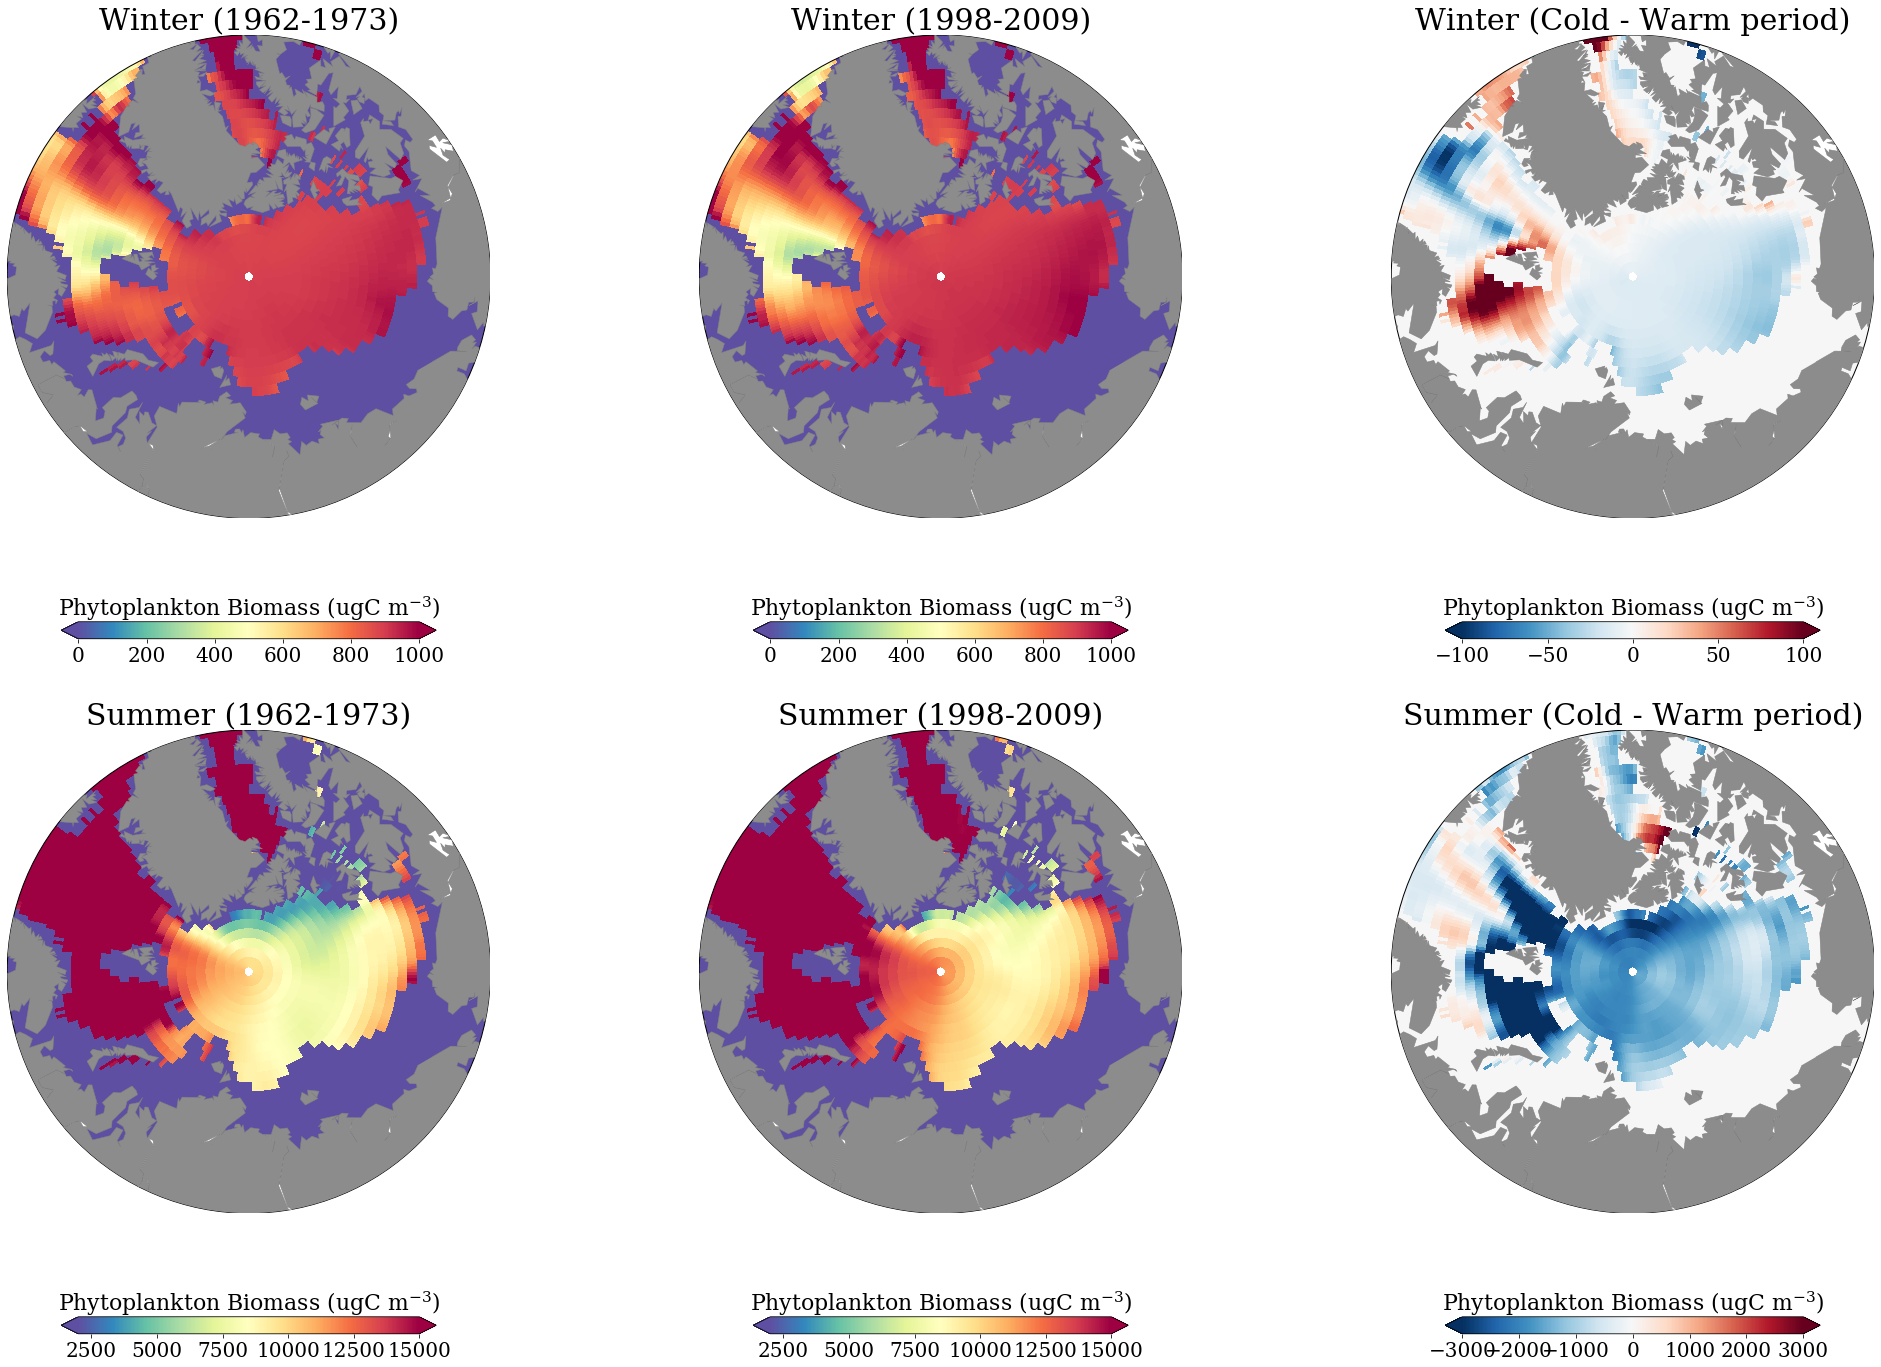

In [70]:
fig = plt.figure(figsize=(30, 20))
lat = mp1C_ds.lat

## WINTER COLD PERIOD
ax = fig.add_subplot(2, 3, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
winter, lon = add_cyclic_point(cold_years[:,list(range(2)) + [-1],:,:].mean(axis=(0,1)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,winter,cmap='Spectral_r', vmin = 0, vmax = 1000)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.5, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('Phytoplankton Biomass (ugC m$^{-3}$)', fontsize=22)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Winter (1962-1973)', fontsize =30)

## WINTER WARM PERDIOD
ax = fig.add_subplot(2, 3, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
winter, lon = add_cyclic_point(warm_years[:,list(range(2)) + [-1],:,:].mean(axis=(0,1)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,winter,cmap='Spectral_r', vmin = 0, vmax = 1000)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.5, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('Phytoplankton Biomass (ugC m$^{-3}$)', fontsize=22)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Winter (1998-2009)', fontsize =30)

## WINTER COLD - WARM PERDIOD
ax = fig.add_subplot(2, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
spring, lon = add_cyclic_point(cold_years[:,list(range(2)) + [-1],:,:].mean(axis=(0,1))- warm_years[:,list(range(2)) + [-1],:,:].mean(axis=(0,1)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,spring,cmap='RdBu_r', vmin = -100, vmax = 100)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.5, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('Phytoplankton Biomass (ugC m$^{-3}$)', fontsize=22)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Winter (Cold - Warm period)', fontsize =30)

## SUMMER COLD PERIOD
ax = fig.add_subplot(2,3, 4)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
summer, lon = add_cyclic_point(cold_years[:,5:8,:,:].mean(axis=(0,1)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,summer,cmap='Spectral_r', vmin = 2000, vmax = 15000)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.5, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('Phytoplankton Biomass (ugC m$^{-3}$)', fontsize=22)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Summer (1962-1973)', fontsize =30)


##SUMMER WARM PERDIOD
ax = fig.add_subplot(2,3, 5)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
summer, lon = add_cyclic_point(warm_years[:,5:8,:,:].mean(axis=(0,1)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,summer,cmap='Spectral_r', vmin = 2000, vmax = 15000)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.5, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('Phytoplankton Biomass (ugC m$^{-3}$)', fontsize=22)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Summer (1998-2009)', fontsize =30)

##SUMMER COLD - WARM PERDIOD
ax = fig.add_subplot(2,3, 6)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
spring, lon = add_cyclic_point(cold_years[:,5:8,:,:].mean(axis=(0,1))- warm_years[:,5:8,:,:].mean(axis=(0,1)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,spring,cmap='RdBu_r', vmin = -3000, vmax = 3000)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.5, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('Phytoplankton Biomass (ugC m$^{-3}$)', fontsize=22)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Summer (Cold - Warm period)', fontsize =30)
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/phyto_biomass_warm_vs_cold_seasonal.png', dpi=600, bbox_inches='tight')

## option 2 : Separate from first and second 20-year period, and try to understand makes those large differences?
* 1990-2009
* 1970-1990

In [22]:
cold_years = phytoC_bm_total[22:42,:,:,:] # 1962-1973
warm_years = phytoC_bm_total[42:62,:,:,:] # 1990-2009

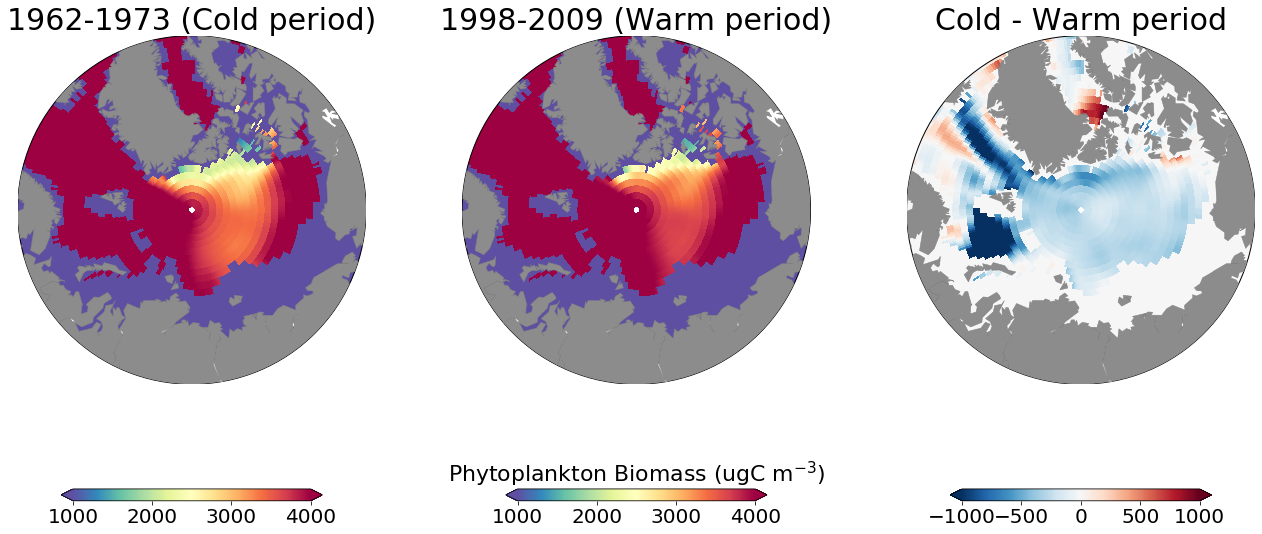

In [23]:
fig = plt.figure(figsize=(18, 10))
lat = mp1C_ds.lat

## Cold Years 
ax = fig.add_subplot(1, 3, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
winter, lon = add_cyclic_point(cold_years.mean(axis=(0,1)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,winter,cmap='Spectral_r', vmin = 1000, vmax = 4000)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.75, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('1962-1973 (Cold period)', fontsize =30)

## Warm Years
ax = fig.add_subplot(1, 3, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
spring, lon = add_cyclic_point(warm_years.mean(axis=(0,1)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,spring,cmap='Spectral_r', vmin = 1000, vmax = 4000)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.75, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('Phytoplankton Biomass (ugC m$^{-3}$)', fontsize=22)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('1998-2009 (Warm period)', fontsize =30)

# Cold - Warm Years 
ax = fig.add_subplot(1, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
spring, lon = add_cyclic_point(cold_years.mean(axis=(0,1))- warm_years.mean(axis=(0,1)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,spring,cmap='RdBu_r', vmin = -1000, vmax = 1000)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.75, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Cold - Warm period', fontsize =30)

fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/phyto_biomass_warm_vs_cold_02.png', dpi=600, bbox_inches='tight')

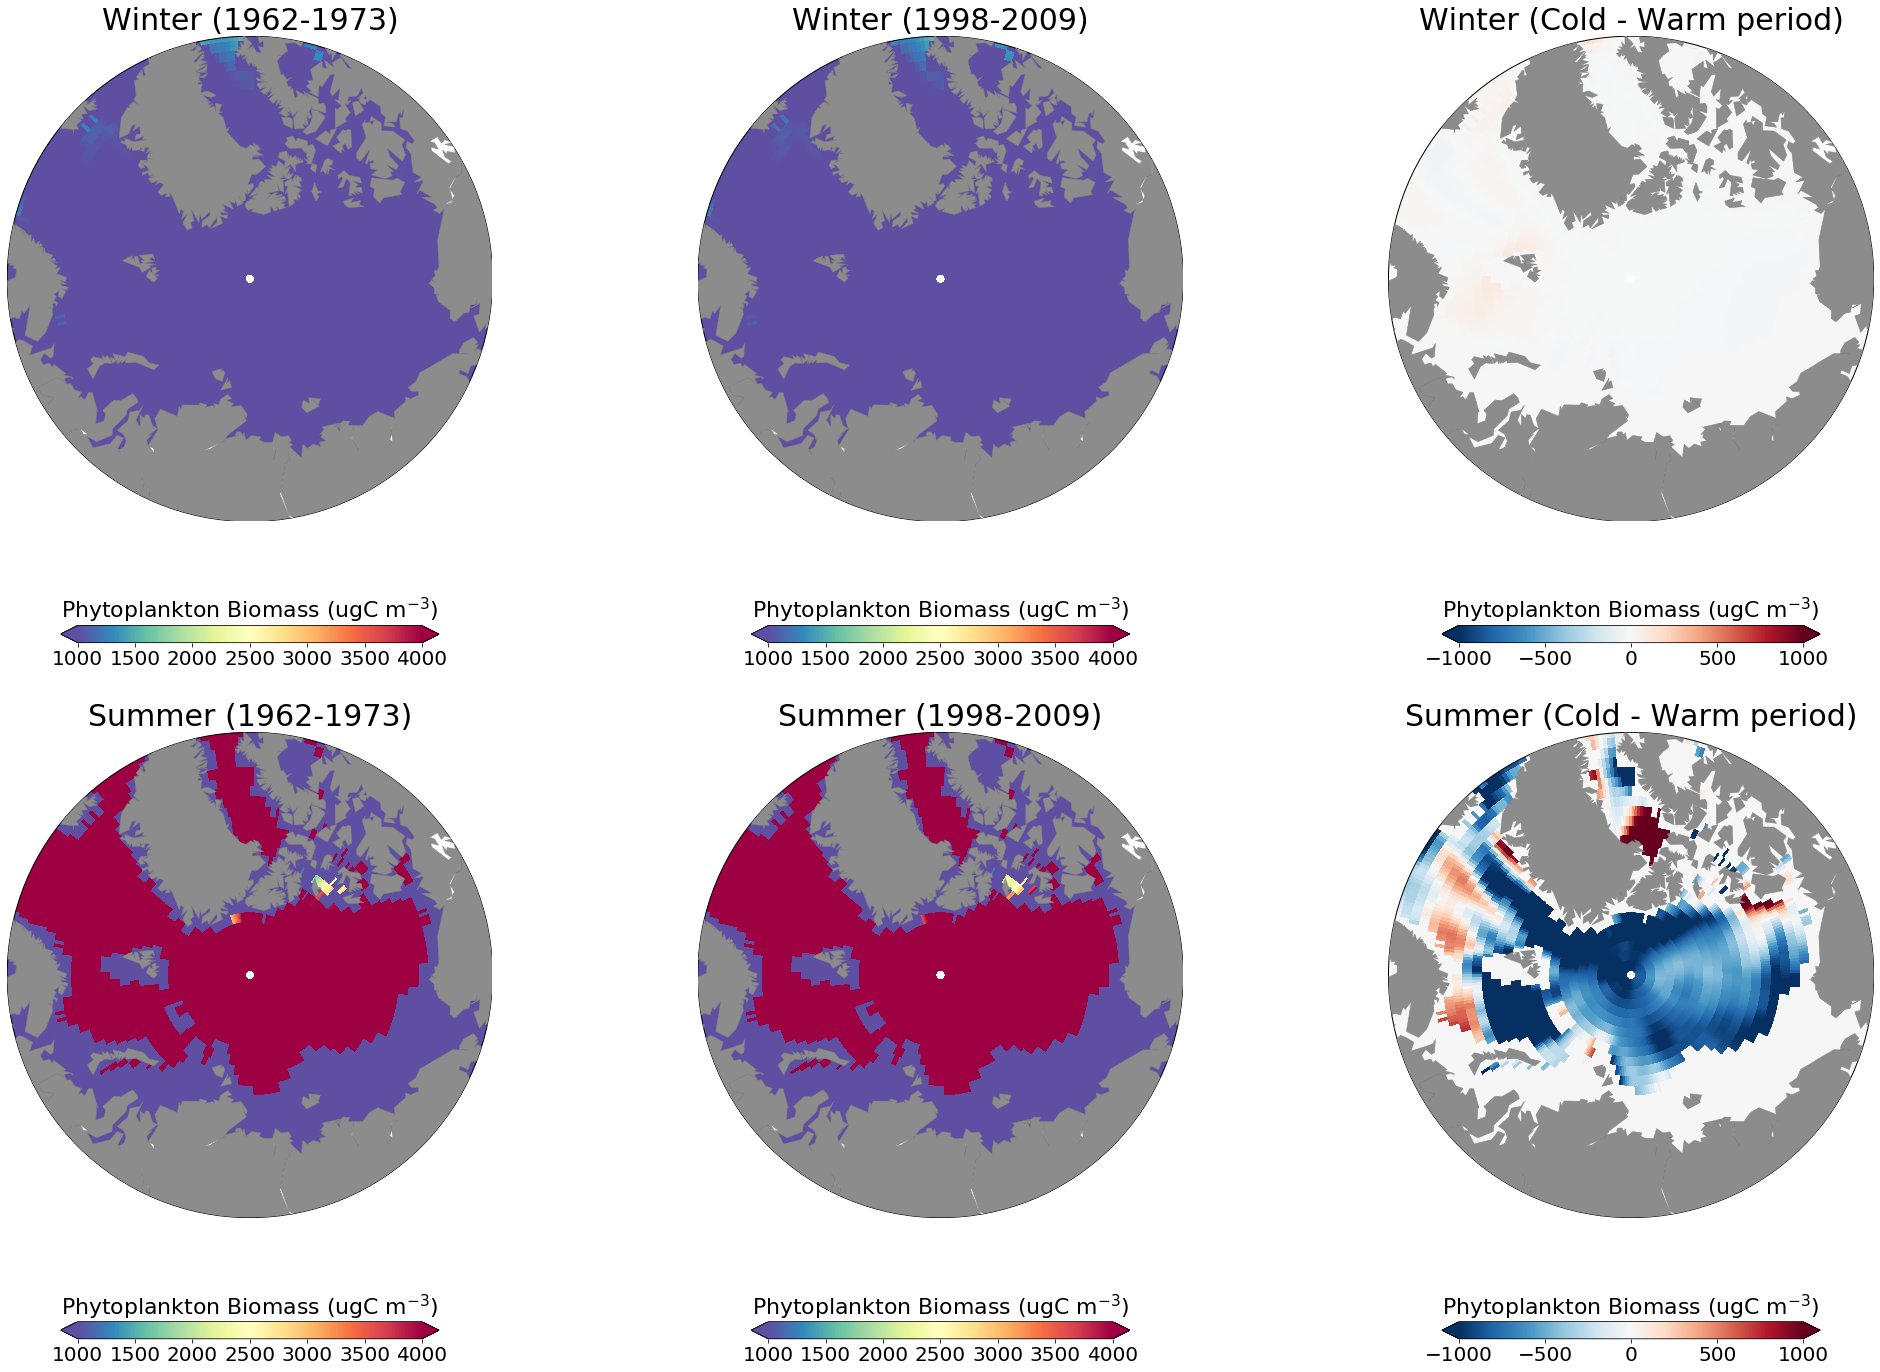

In [24]:
fig = plt.figure(figsize=(30, 20))
lat = mp1C_ds.lat

## WINTER COLD PERIOD
ax = fig.add_subplot(2, 3, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
winter, lon = add_cyclic_point(cold_years[:,list(range(2)) + [-1],:,:].mean(axis=(0,1)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,winter,cmap='Spectral_r', vmin = 0, vmax = 1000)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.5, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('Phytoplankton Biomass (ugC m$^{-3}$)', fontsize=22)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Winter (1962-1973)', fontsize =30)

## WINTER WARM PERDIOD
ax = fig.add_subplot(2, 3, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
winter, lon = add_cyclic_point(warm_years[:,list(range(2)) + [-1],:,:].mean(axis=(0,1)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,winter,cmap='Spectral_r', vmin = 1000, vmax = 4000)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.5, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('Phytoplankton Biomass (ugC m$^{-3}$)', fontsize=22)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Winter (1998-2009)', fontsize =30)

## WINTER COLD - WARM PERDIOD
ax = fig.add_subplot(2, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
spring, lon = add_cyclic_point(cold_years[:,list(range(2)) + [-1],:,:].mean(axis=(0,1))- warm_years[:,list(range(2)) + [-1],:,:].mean(axis=(0,1)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,spring,cmap='RdBu_r', vmin = -1000, vmax = 1000)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.5, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('Phytoplankton Biomass (ugC m$^{-3}$)', fontsize=22)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Winter (Cold - Warm period)', fontsize =30)

## SUMMER COLD PERIOD
ax = fig.add_subplot(2,3, 4)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
summer, lon = add_cyclic_point(cold_years[:,5:8,:,:].mean(axis=(0,1)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,summer,cmap='Spectral_r', vmin = 1000, vmax = 4000)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.5, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('Phytoplankton Biomass (ugC m$^{-3}$)', fontsize=22)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Summer (1962-1973)', fontsize =30)


##SUMMER WARM PERDIOD
ax = fig.add_subplot(2,3, 5)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
summer, lon = add_cyclic_point(warm_years[:,5:8,:,:].mean(axis=(0,1)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,summer,cmap='Spectral_r', vmin = 1000, vmax = 4000)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.5, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('Phytoplankton Biomass (ugC m$^{-3}$)', fontsize=22)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Summer (1998-2009)', fontsize =30)

##SUMMER COLD - WARM PERDIOD
ax = fig.add_subplot(2,3, 6)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
spring, lon = add_cyclic_point(cold_years[:,5:8,:,:].mean(axis=(0,1))- warm_years[:,5:8,:,:].mean(axis=(0,1)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,spring,cmap='RdBu_r', vmin = -1000, vmax = 1000)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.5, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('Phytoplankton Biomass (ugC m$^{-3}$)', fontsize=22)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Summer (Cold - Warm period)', fontsize =30)
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/phyto_biomass_warm_vs_cold_seasonal_02.png', dpi=600, bbox_inches='tight')

## Biomass for each size class

In [8]:
phytoC_ds_inter.shape

(9, 63, 12, 15, 180, 360)

In [16]:
# UNITS, we start with mmolC/m^3, but want to integrate with depth, so we multiply by 10m depths, and divide by depth total (150m)!
phytoC_bm = np.sum(phytoC_ds_inter, axis=3) * 10 #integrate over depth #mmol m-2
#phytoC_bm_ugm3 = phytoC_bm * 12.011 *1000 # ug C m-3 --> ugC m^{-3}

In [17]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 15),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'font.family':'serif',
         'font.size': 12}
pylab.rcParams.update(params)

In [18]:
import seaborn as sns
import scipy.io as sio

In [13]:
np.nanmean(phytoC_bm[:,14:26,:,149:180,:], axis=(1,2,3,4)).shape

(9,)

In [19]:
cold_years = phytoC_bm[:,cold_years_arctic,:,149:180,:] # 1/2 standard deviation 
warm_years = phytoC_bm[:,warm_years_arctic,:,149:180,:] # 1/2 standard deviation 

In [20]:
cold_years.shape

(9, 1, 19, 12, 31, 360)

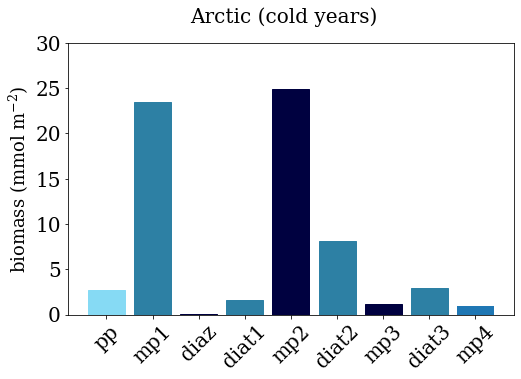

In [23]:
fig = plt.figure(figsize=(8, 5)) 
barWidth=1
x = months = ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec')
xx = phyto_vars = ['pp','mp1','diaz','diat1','mp2','diat2','mp3','diat3','mp4']

ax = fig.add_subplot(1, 1, 1)
barlist = ax.bar(xx,np.nanmean(cold_years, axis=(1,2,3,4,5)))
barlist[0].set_color('#86daf4') # picoplankton
barlist[1].set_color('#2d80a4') # mixed phytoplankton 
#barlist[2].set_color('#60baf7') # diazotrophs 
barlist[2].set_color('#000140') # diatom 
barlist[3].set_color('#2d80a4') # mixed phytoplankton 
barlist[4].set_color('#000140') # diatom 
barlist[5].set_color('#2d80a4') # mixed phytoplankton 
barlist[6].set_color('#000140') # diatom 
barlist[7].set_color('#2d80a4') # mixed phytoplankton 
ax.set_ylim([0,30])
ax.set_xticklabels(phyto_vars, rotation = 45, fontsize=20)
ax.set_yticklabels([0,5,10,15,20,25,30], fontsize=20)
ax.set_ylabel('biomass (mmol m$^{-2}$)',fontsize=24 )
#ax.set_title('summer', fontsize=18)

fig.suptitle('Arctic (cold years)', fontsize=20)
ax.set_ylabel('biomass (mmol m$^{-2}$)',fontsize=18 )
figures_file = '/glade/u/home/gabyn/case_notes/analysis_figures'
fig.savefig(''+figures_file+'/GNG595/Phyto_biomass_AO_cold_years_bar_50std.png')

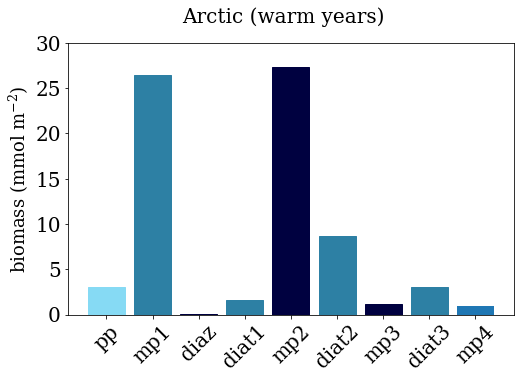

In [24]:
fig = plt.figure(figsize=(8, 5)) 
barWidth=1
x = months = ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec')
xx = phyto_vars = ['pp','mp1','diaz','diat1','mp2','diat2','mp3','diat3','mp4']

ax = fig.add_subplot(1, 1, 1)
barlist = ax.bar(xx,np.nanmean(warm_years, axis=(1,2,3,4,5)))
barlist[0].set_color('#86daf4') # picoplankton
barlist[1].set_color('#2d80a4') # mixed phytoplankton 
#barlist[2].set_color('#60baf7') # diazotrophs 
barlist[2].set_color('#000140') # diatom 
barlist[3].set_color('#2d80a4') # mixed phytoplankton 
barlist[4].set_color('#000140') # diatom 
barlist[5].set_color('#2d80a4') # mixed phytoplankton 
barlist[6].set_color('#000140') # diatom 
barlist[7].set_color('#2d80a4') # mixed phytoplankton 
ax.set_ylim([0,30])
ax.set_xticklabels(phyto_vars, rotation = 45, fontsize=20)
ax.set_yticklabels([0,5,10,15,20,25,30], fontsize=20)
ax.set_ylabel('biomass (mmol m$^{-2}$)',fontsize=24 )
#ax.set_title('summer', fontsize=18)

    
fig.suptitle('Arctic (warm years)', fontsize=20)
ax.set_ylabel('biomass (mmol m$^{-2}$)',fontsize=18 )
figures_file = '/glade/u/home/gabyn/case_notes/analysis_figures'
fig.savefig(''+figures_file+'/GNG595/Phyto_biomass_AO_warm_years_bar_50std.png')

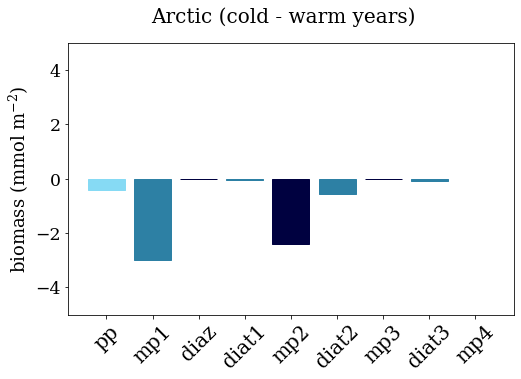

In [26]:
fig = plt.figure(figsize=(8, 5)) 
barWidth=1
x = months = ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec')
xx = phyto_vars = ['pp','mp1','diaz','diat1','mp2','diat2','mp3','diat3','mp4']

ax = fig.add_subplot(1, 1, 1)
barlist = ax.bar(xx,np.nanmean(cold_years, axis=(1,2,3,4,5))-np.nanmean(warm_years, axis=(1,2,3,4,5)))
barlist[0].set_color('#86daf4') # picoplankton
barlist[1].set_color('#2d80a4') # mixed phytoplankton 
#barlist[2].set_color('#60baf7') # diazotrophs 
barlist[2].set_color('#000140') # diatom 
barlist[3].set_color('#2d80a4') # mixed phytoplankton 
barlist[4].set_color('#000140') # diatom 
barlist[5].set_color('#2d80a4') # mixed phytoplankton 
barlist[6].set_color('#000140') # diatom 
barlist[7].set_color('#2d80a4') # mixed phytoplankton 
ax.set_ylim([-5,5])
ax.set_xticklabels(phyto_vars, rotation = 45, fontsize=20)
#ax.set_yticklabels(fontsize=20)
ax.set_ylabel('biomass (mmol m$^{-2}$)',fontsize=24 )
#ax.set_title('summer', fontsize=18)

    
fig.suptitle('Arctic (cold - warm years)', fontsize=20)
ax.set_ylabel('biomass (mmol m$^{-2}$)',fontsize=18 )
figures_file = '/glade/u/home/gabyn/case_notes/analysis_figures'
fig.savefig(''+figures_file+'/GNG595/Phyto_biomass_AO_cold_vs_warm_years_bar_50std.png')

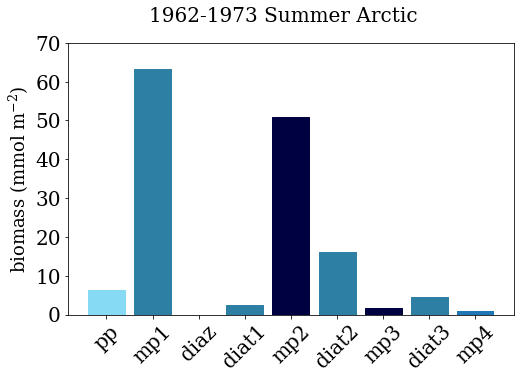

In [23]:
fig = plt.figure(figsize=(8, 5)) 
barWidth=1
x = months = ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec')
xx = phyto_vars = ['pp','mp1','diaz','diat1','mp2','diat2','mp3','diat3','mp4']

ax = fig.add_subplot(1, 1, 1)
barlist = ax.bar(xx,np.nanmean(phytoC_bm[:,14:26,5:8,149:180,:], axis=(1,2,3,4)))
barlist[0].set_color('#86daf4') # picoplankton
barlist[1].set_color('#2d80a4') # mixed phytoplankton 
#barlist[2].set_color('#60baf7') # diazotrophs 
barlist[2].set_color('#000140') # diatom 
barlist[3].set_color('#2d80a4') # mixed phytoplankton 
barlist[4].set_color('#000140') # diatom 
barlist[5].set_color('#2d80a4') # mixed phytoplankton 
barlist[6].set_color('#000140') # diatom 
barlist[7].set_color('#2d80a4') # mixed phytoplankton 
ax.set_ylim([0,70])
ax.set_xticklabels(phyto_vars, rotation = 45, fontsize=20)
ax.set_yticklabels([0,10,20,30,40,50,60,70], fontsize=20)
ax.set_ylabel('biomass (mmol m$^{-2}$)',fontsize=24 )
#ax.set_title('summer', fontsize=18)

fig.suptitle('1962-1973 Summer Arctic', fontsize=20)
ax.set_ylabel('biomass (mmol m$^{-2}$)',fontsize=18 )
figures_file = '/glade/u/home/gabyn/case_notes/analysis_figures'
fig.savefig(''+figures_file+'/GNG595/Phyto_biomass_AO_summer_cold_years_bar.png')

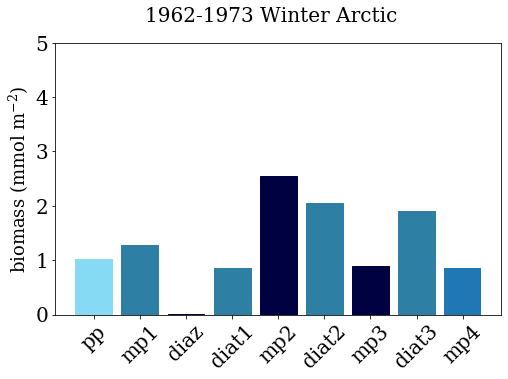

In [30]:
fig = plt.figure(figsize=(8, 5)) 
barWidth=1
x = months = ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec')
xx = phyto_vars = ['pp','mp1','diaz','diat1','mp2','diat2','mp3','diat3','mp4']

ax = fig.add_subplot(1, 1, 1)
barlist = ax.bar(xx,np.nanmean(phytoC_bm[:,14:26,list(range(2)) + [-1],149:180,:], axis=(1,2,3,4)))
barlist[0].set_color('#86daf4') # picoplankton
barlist[1].set_color('#2d80a4') # mixed phytoplankton 
#barlist[2].set_color('#60baf7') # diazotrophs 
barlist[2].set_color('#000140') # diatom 
barlist[3].set_color('#2d80a4') # mixed phytoplankton 
barlist[4].set_color('#000140') # diatom 
barlist[5].set_color('#2d80a4') # mixed phytoplankton 
barlist[6].set_color('#000140') # diatom 
barlist[7].set_color('#2d80a4') # mixed phytoplankton 
ax.set_ylim([0,5])
ax.set_xticklabels(phyto_vars, rotation = 45, fontsize=20)
ax.set_yticklabels([0,1,2,3,4,5], fontsize=20)
ax.set_ylabel('biomass (mmol m$^{-2}$)',fontsize=24 )
#ax.set_title('summer', fontsize=18)

fig.suptitle('1962-1973 Winter Arctic', fontsize=20)
ax.set_ylabel('biomass (mmol m$^{-2}$)',fontsize=18 )
figures_file = '/glade/u/home/gabyn/case_notes/analysis_figures'
fig.savefig(''+figures_file+'/GNG595/Phyto_biomass_AO_winter_cold_years_bar.png')

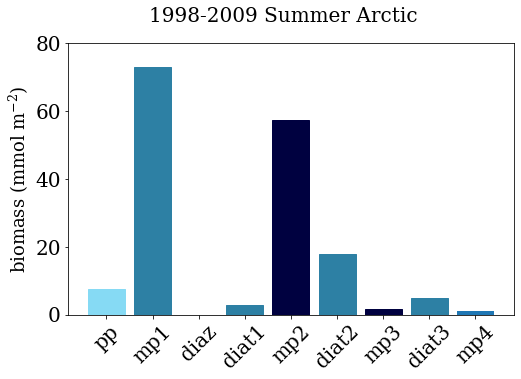

In [26]:
fig = plt.figure(figsize=(8, 5)) 
barWidth=1
x = months = ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec')
xx = phyto_vars = ['pp','mp1','diaz','diat1','mp2','diat2','mp3','diat3','mp4']

ax = fig.add_subplot(1, 1, 1)
barlist = ax.bar(xx,np.nanmean(phytoC_bm[:,51:62,5:8,149:180,:], axis=(1,2,3,4)))
barlist[0].set_color('#86daf4') # picoplankton
barlist[1].set_color('#2d80a4') # mixed phytoplankton 
#barlist[2].set_color('#60baf7') # diazotrophs 
barlist[2].set_color('#000140') # diatom 
barlist[3].set_color('#2d80a4') # mixed phytoplankton 
barlist[4].set_color('#000140') # diatom 
barlist[5].set_color('#2d80a4') # mixed phytoplankton 
barlist[6].set_color('#000140') # diatom 
barlist[7].set_color('#2d80a4') # mixed phytoplankton 
ax.set_ylim([0,80])
ax.set_xticklabels(phyto_vars, rotation = 45, fontsize=20)
ax.set_yticklabels([0,20,40,60,80], fontsize=20)
ax.set_ylabel('biomass (mmol m$^{-2}$)',fontsize=24 )
#ax.set_title('summer', fontsize=18)

    
fig.suptitle('1998-2009 Summer Arctic', fontsize=20)
ax.set_ylabel('biomass (mmol m$^{-2}$)',fontsize=18 )
figures_file = '/glade/u/home/gabyn/case_notes/analysis_figures'
fig.savefig(''+figures_file+'/GNG595/Phyto_biomass_AO_summer_warm_years_bar.png')

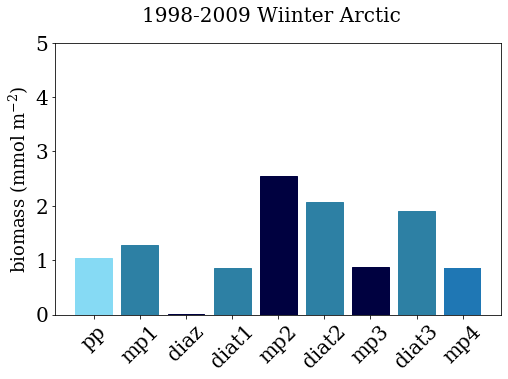

In [29]:
fig = plt.figure(figsize=(8, 5)) 
barWidth=1
x = months = ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec')
xx = phyto_vars = ['pp','mp1','diaz','diat1','mp2','diat2','mp3','diat3','mp4']

ax = fig.add_subplot(1, 1, 1)
barlist = ax.bar(xx,np.nanmean(phytoC_bm[:,51:62,list(range(2)) + [-1],149:180,:], axis=(1,2,3,4)))
barlist[0].set_color('#86daf4') # picoplankton
barlist[1].set_color('#2d80a4') # mixed phytoplankton 
#barlist[2].set_color('#60baf7') # diazotrophs 
barlist[2].set_color('#000140') # diatom 
barlist[3].set_color('#2d80a4') # mixed phytoplankton 
barlist[4].set_color('#000140') # diatom 
barlist[5].set_color('#2d80a4') # mixed phytoplankton 
barlist[6].set_color('#000140') # diatom 
barlist[7].set_color('#2d80a4') # mixed phytoplankton 
ax.set_ylim([0,5])
ax.set_xticklabels(phyto_vars, rotation = 45, fontsize=20)
ax.set_yticklabels([0,1,2,3,4,5], fontsize=20)
ax.set_ylabel('biomass (mmol m$^{-2}$)',fontsize=24 )
#ax.set_title('summer', fontsize=18)

    
fig.suptitle('1998-2009 Wiinter Arctic', fontsize=20)
ax.set_ylabel('biomass (mmol m$^{-2}$)',fontsize=18 )
figures_file = '/glade/u/home/gabyn/case_notes/analysis_figures'
fig.savefig(''+figures_file+'/GNG595/Phyto_biomass_AO_winter_warm_years_bar.png')